# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection


# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# ROC , AUC curve
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
# kFold
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

from joblib import dump, load
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier

from wordcloud import WordCloud

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 85000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (85000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(75844, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

89.22823529411764

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(75842, 10)


1    63459
0    12383
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
These were just adorable when used on a bee hive cake!  In the right setting they add that special designer touch to a cake that can turn a nice cake to a piece of edible art.
This is the BEST!<br />Years ago, I used it & loved it! Moved & could not find it again. I have purchased many hot/sweet sauces over the years, trying to find this flavor. Recently, I found it again at World Market....now I'm addicted! Everyone has mentioned great ways to use it.<br />My favorite....I use it on my salads, along with a little fat-free dressing. Now, I eat tasty salads every day, (without the cheese!).<br /><br />Sodium is 200 mg per tablespoon....and the amount of added flavor is wo

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
These were just adorable when used on a bee hive cake!  In the right setting they add that special designer touch to a cake that can turn a nice cake to a piece of edible art.
This is the BEST!Years ago, I used it & loved it! Moved & could not find it again. I have purchased many hot/sweet sauces over the years, trying to find this flavor. Recently, I found it again at World Market....now I'm addicted! Everyone has mentioned great ways to use it.My favorite....I use it on my salads, along with a little fat-free dressing. Now, I eat tasty salads every day, (without the cheese!).Sodium is 200 mg per tablespoon....and the amount of added flavor is worth every mg!
This produ

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the BEST!<br />Years ago, I used it & loved it! Moved & could not find it again. I have purchased many hot/sweet sauces over the years, trying to find this flavor. Recently, I found it again at World Market....now I am addicted! Everyone has mentioned great ways to use it.<br />My favorite....I use it on my salads, along with a little fat-free dressing. Now, I eat tasty salads every day, (without the cheese!).<br /><br />Sodium is 200 mg per tablespoon....and the amount of added flavor is worth every mg!


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the BEST br Years ago I used it loved it Moved could not find it again I have purchased many hot sweet sauces over the years trying to find this flavor Recently I found it again at World Market now I am addicted Everyone has mentioned great ways to use it br My favorite I use it on my salads along with a little fat free dressing Now I eat tasty salads every day without the cheese br br Sodium is 200 mg per tablespoon and the amount of added flavor is worth every mg 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar
word_counter = []
def filterised_text(text):
    preprocessed_text = []
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        count = len(sentance.split())
        word_counter.append(count)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text

In [23]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1822]

100%|██████████| 75842/75842 [00:23<00:00, 3265.52it/s]


'fell love product england boyfriend sandwich branston never want eat sandwich without delicious wish sold product hawaii not pay high shipping cost bring however delicious wanted bring could eat feel like back england branstolicious'

In [24]:
final['numbers_of_words']  = word_counter
word_counter[1822]

34

### [3.2] Preprocessing Review Summary

In [25]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 75842/75842 [00:13<00:00, 5443.31it/s]


'branstolicious'

In [26]:
avg_w2v_trained_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_100000'
avg_w2v_test_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_100000'

w2v_tf_idf_trained_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_100000'
w2v_tf_idf_test_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_100000'

In [27]:
depth_ = [2,5,7,10,25,50,100,200,250]
depth_ = np.asarray(depth_)

estimators = [25,50,100,250,500,1000]
estimators_list = np.asarray(estimators)


def finding_best_hyperparam(X_tr,y_tr):
    # instantiate a Random Forest model
    rf = RandomForestClassifier(class_weight='balanced', random_state=1)
    
    param_grid=dict(n_estimators=estimators_list,max_depth=depth_)

    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=10) 
    
    # instantiate the training grid search model
    train_grid = GridSearchCV(rf, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=8 )
    
    # fit the training data to train model
    train_grid.fit(X_tr, y_tr)

    return train_grid

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# plot AUC curve
def plotAUC_ROC(model,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = model.predict_proba(X_test)
    train_probs = model.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

    
# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    # calculate confusion matrix
    cm =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(cm, index=class_label, columns=class_label)
    # heatmap --> Plot rectangular data as a color-encoded matrix. 
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    # give title to graph
    plt.title("Confusion Matrix")
    # mention axis label
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    # show the plot
    plt.show()
    
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# https://qiita.com/bmj0114/items/8009f282c99b77780563
def plotHeatMap(trained_model, param):
    
    if param == 'trained':
        scores = trained_model.cv_results_['mean_train_score'].reshape(len(estimators_list),len(depth_))
    else:
        scores = trained_model.cv_results_['mean_test_score'].reshape(len(estimators_list),len(depth_))

    plt.figure(figsize=(16, 12))
    sns.heatmap(scores, annot=True, cmap=plt.cm.hot, fmt=".3f", xticklabels=estimators_list, yticklabels=depth_)
    plt.xlabel('n_estimators')
    plt.ylabel('max_depth')
    plt.xticks(np.arange(len(estimators_list)), estimators_list)
    plt.yticks(np.arange(len(depth_)), depth_)
    plt.title('Grid Search AUC Score')
    plt.show()

# [4] Featurization

### Splitting data

__We have considered 100 k points__

In [44]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(53089,) (22753,) (53089,) (22753,)


## [4.1] BAG OF WORDS

In [45]:
##BoW

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn

# train data
X_train_bow = count_vect.fit_transform(X_train)

# test data
x_test_bow = count_vect.transform(x_test)


print('X_train_bow',X_train_bow.shape)
print('==='*10)
print('x_test_bow',x_test_bow.shape)

X_train_bow (53089, 31683)
x_test_bow (22753, 31683)


### Hyper param Tuning using GridSearch

##### finding 'max depth' &  'esimate models'  which have maximum AUC Score

In [30]:
bow_train_path = '/home/pranay/ML Hyperparam Tune/RF/bow_train_hyperparam_tuned'
exists = os.path.isfile(bow_train_path)

if exists:
    print("yes exists")
    bow_train = load(bow_train_path)
else:
    print("not exists")
    bow_train = finding_best_hyperparam(X_train_bow,y_train)
    dump(bow_train,bow_train_path )


# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

# plotAccuracyGraph(bow_train,'n_estimators')
best_estimators = bow_train.best_params_.get("n_estimators","")
best_depth_size = bow_train.best_params_.get("max_depth", "")

best_estimators, best_depth_size

yes exists
=======Training========
0.9416894957709031
{'max_depth': 200, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=200, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1, verbose=0, warm_start=False)


(1000, 200)


AUC Train data


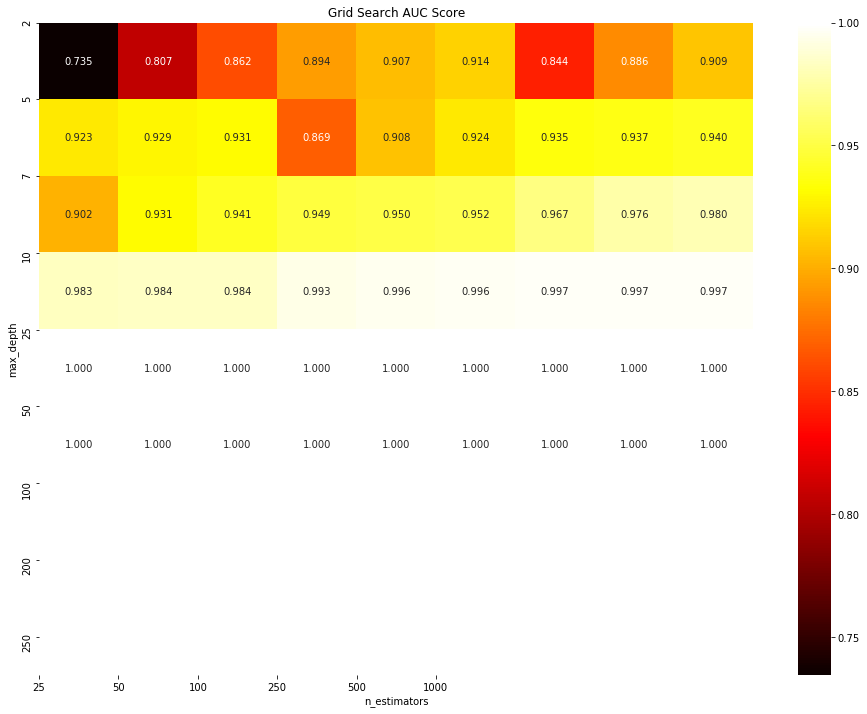

In [31]:
print('\n'+color.BOLD +'AUC Train data'+color.END)
plotHeatMap(bow_train,'trained')


AUC Validation data


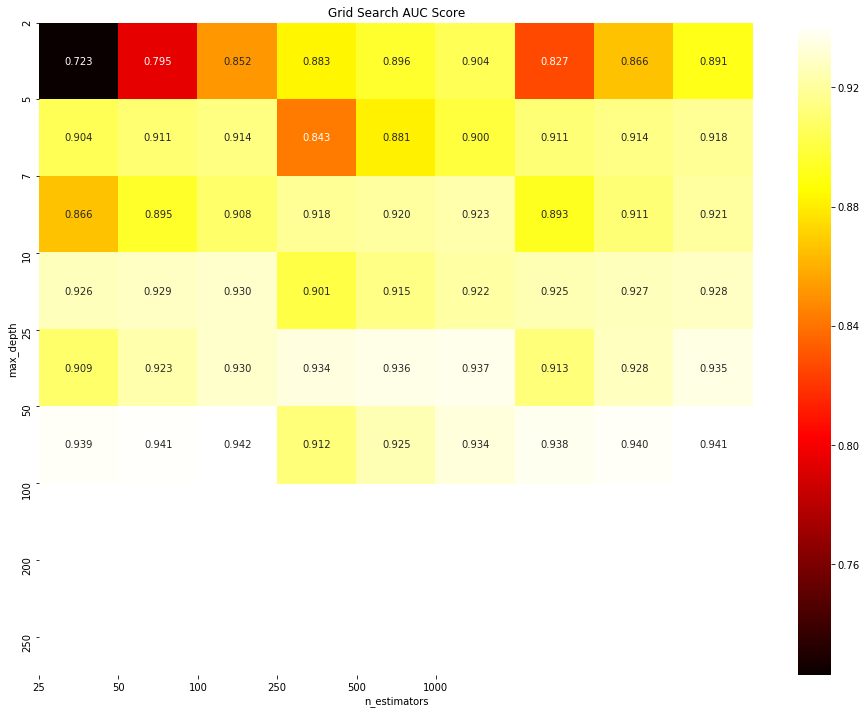

In [32]:
print('\n'+color.BOLD +'AUC Validation data'+color.END)
plotHeatMap(bow_train,'test')

###  Applying Random Forests on BOW


Max Depth : 5

Best Estimator : 500

Confusion Matrix for Train data


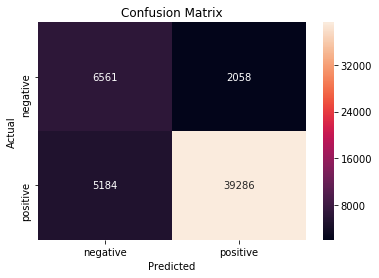


Confusion Matrix for Test data


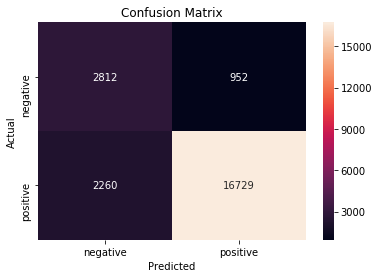

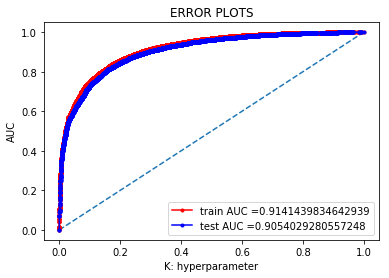


AUC (Train): 0.9141439834642939

AUC (Test): 0.9054029280557248

F1 SCORE (Train) : 0.915608175822127

F1 SCORE (Test) : 0.9124079629124624

RECALL (Train): 0.8834270294580616

RECALL (Test): 0.8809837274211385

PRECISION  (Train) : 0.9502225232198143

PRECISION  (Test) : 0.9461568915785307


In [46]:
optimal_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=1, verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(X_train_bow, y_train)

# predict the response
test_pred = optimal_model.predict(x_test_bow)
train_pred = optimal_model.predict(X_train_bow)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(5)+color.END)
print('\n'+color.RED+'Best Estimator : '+color.END+color.BOLD+str(500)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,X_train_bow, y_train,x_test_bow, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### Top 20 features

In [34]:
topn_class = sorted(zip(optimal_model.feature_importances_, count_vect.get_feature_names()),reverse=True)[:20]
top_words_ = ''
for feature, value in topn_class:
    print(feature, value)
    top_words_ +=' ' +value

0.027831871979637258 not
0.019400895119037663 bad
0.017125433830493485 money
0.01574504233922165 worst
0.014832038301706561 best
0.012383367527177625 would not
0.01196082665669607 highly recommend
0.01183968678226365 would
0.011736804588396281 great
0.011488458301315068 love
0.010978625549449495 waste
0.010745350421785519 awful
0.010479627476945298 loves
0.01024628177735379 not recommend
0.009638915368363704 perfect
0.009605851646922977 disappointed
0.00936065121090504 highly
0.009144239234927454 opened
0.009054157026683649 tasted
0.008996833500174342 favorite


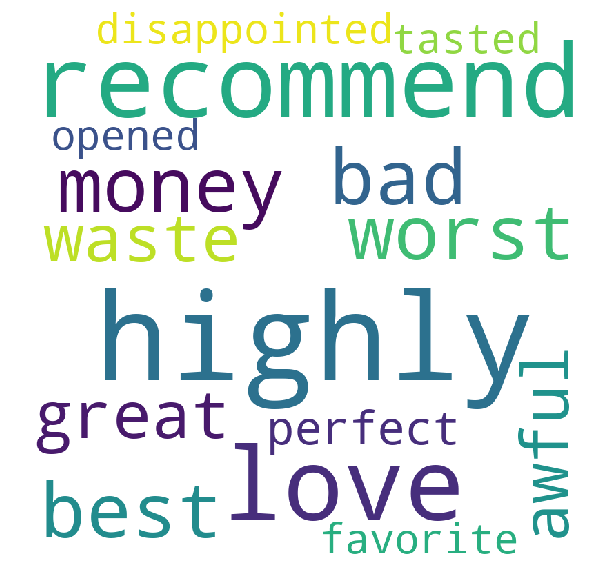

In [35]:
#  https://www.geeksforgeeks.org/generating-word-cloud-python/

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(top_words_) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(21000, 13) (9000, 13) (21000,) (9000,)

Confusion Matrix for Train data


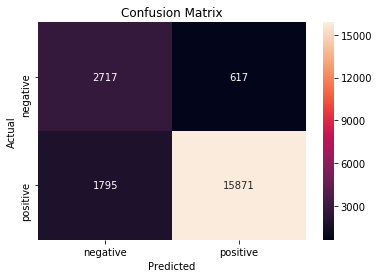


Confusion Matrix for Test data


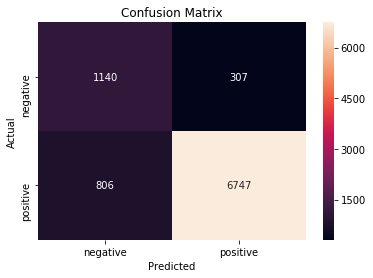

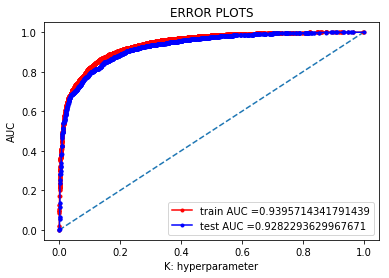


AUC (Train): 0.9395714341791439

AUC (Test): 0.9282293629967671

F1 SCORE (Train) : 0.929378696492358

F1 SCORE (Test) : 0.9238036557814746

RECALL (Train): 0.8983923921657421

RECALL (Test): 0.8932874354561101

PRECISION  (Train) : 0.9625788452207666

PRECISION  (Test) : 0.9564785937056989


In [36]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:30000]
y = final['Score'][:30000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', CountVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=1, verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(train_features,y_train)

# predict the response
test_pred = optimal_model.predict(test_features)
train_pred = optimal_model.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.3] TF-IDF

In [31]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), min_df=10) #in scikit-learn

# train data
X_train_tfidf = tf_idf_vect.fit_transform(X_train)

# test data
x_test_tfidf = tf_idf_vect.transform(x_test)

print('X_train_tfidf', X_train_tfidf.shape)
print('==='*10)
print('x_test_tfidf', x_test_tfidf.shape)

(53089,) (22753,) (53089,) (22753,)
X_train_tfidf (53089, 34425)
x_test_tfidf (22753, 34425)


### Hyper param Tuning using GridSearch

##### finding 'max depth' &  'esimate models'  which have maximum AUC Score

In [47]:
tfidf_train_path = '/home/pranay/ML Hyperparam Tune/RF/tfidf_train_hyperparam_tuned'
exists = os.path.isfile(tfidf_train_path)

if exists:
    print("yes exists")
    tfidf_train = load(tfidf_train_path)
else:
    print("not exists")
    tfidf_train = finding_best_hyperparam(X_train_tfidf,y_train)
    dump(tfidf_train,tfidf_train_path )
    
    
# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

best_depth_size = tfidf_train.best_params_.get("max_depth", "")
best_estimators = tfidf_train.best_params_.get("n_estimators", "")

yes exists
=======Training========
0.9412546995742181
{'max_depth': 200, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=200, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1, verbose=0, warm_start=False)



AUC Train data


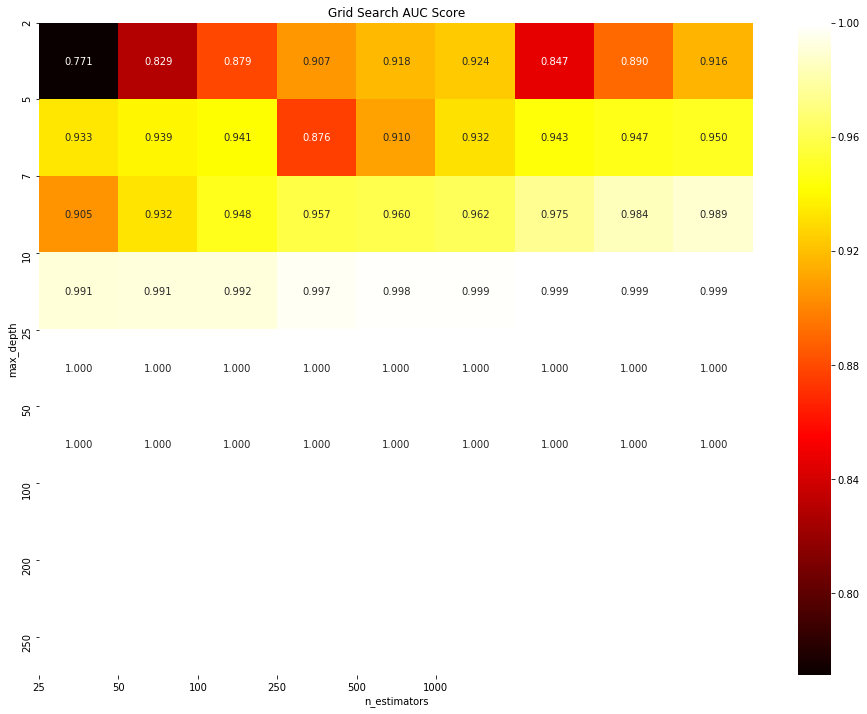

In [48]:
print('\n'+color.BOLD +'AUC Train data'+color.END)
plotHeatMap(tfidf_train,'trained')


AUC Validation data


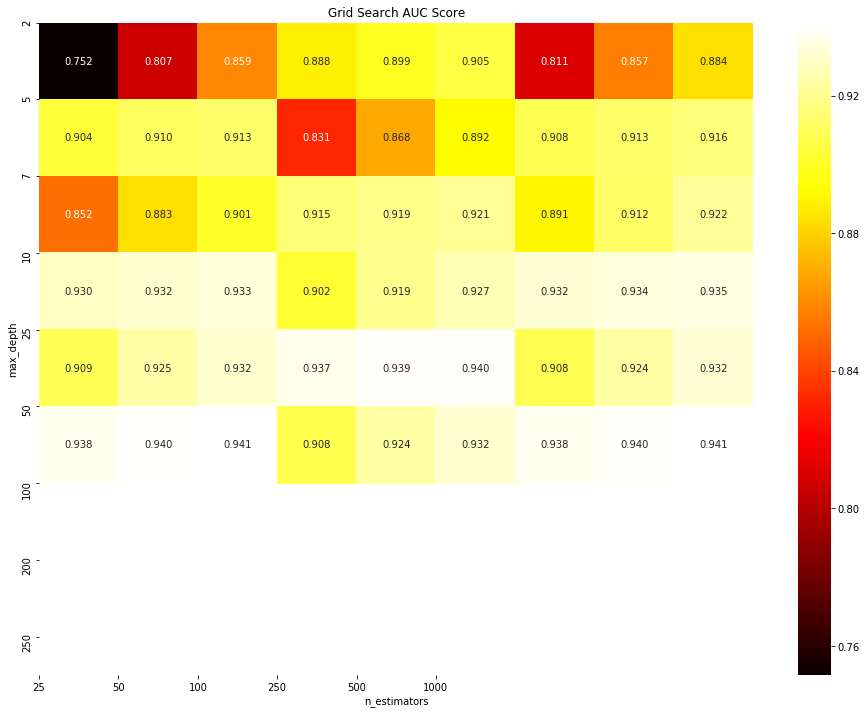

In [49]:
print('\n'+color.BOLD +'AUC Validation data'+color.END)
plotHeatMap(tfidf_train,'test')


Max Depth : 7

Best Estimator : 1000

Confusion Matrix for Train data


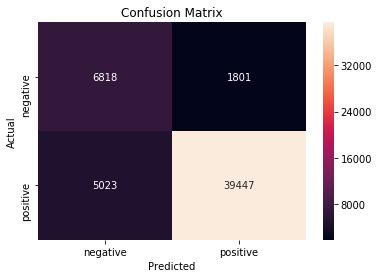


Confusion Matrix for Test data


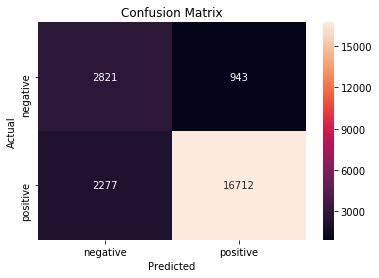

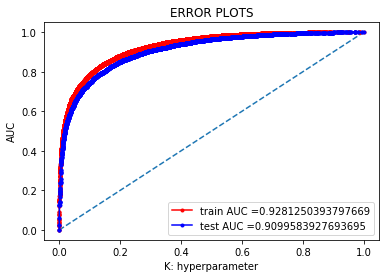


AUC (Train): 0.9281250393797669

AUC (Test): 0.9099583927693695

F1 SCORE (Train) : 0.920390116428288

F1 SCORE (Test) : 0.9121274969981443

RECALL (Train): 0.8870474477175624

RECALL (Test): 0.8800884722734215

PRECISION  (Train) : 0.9563372769588828

PRECISION  (Test) : 0.9465873690172756


In [32]:
optimal_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=1, verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(X_train_tfidf, y_train)

# predict the response
test_pred = optimal_model.predict(x_test_tfidf)
train_pred = optimal_model.predict(X_train_tfidf)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(7)+color.END)
print('\n'+color.RED+'Best Estimator : '+color.END+color.BOLD+str(1000)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,X_train_tfidf, y_train,x_test_tfidf, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## Top 20 Features

In [33]:
topn_class = sorted(zip(optimal_model.feature_importances_, tf_idf_vect.get_feature_names()),reverse=True)[:20]
top_words_tfidf = ''
for feature, value in topn_class:
    print(feature, value)
    top_words_tfidf +=' ' +value

0.028596485544315618 not
0.02395906199265078 great
0.01947601021875896 love
0.014719903913763101 best
0.01353386199499219 bad
0.013514055672606213 disappointed
0.012205310566930508 would
0.011325506865143201 delicious
0.010450019579856936 not buy
0.010423995226447564 return
0.01032609213769831 money
0.00939346414982737 would not
0.009347834068748203 worst
0.008967119279491946 favorite
0.008896638776258946 loves
0.008795024928461424 awful
0.008752303540848324 terrible
0.008509588121660971 horrible
0.008457914997540379 away
0.008358680482896601 highly recommend


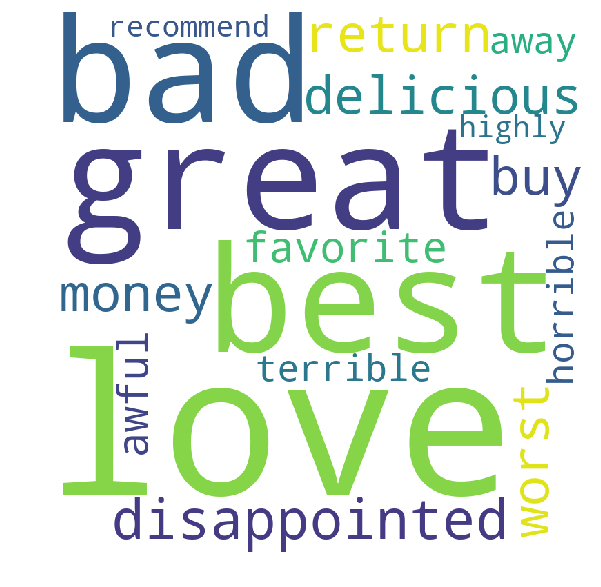

In [34]:
#  https://www.geeksforgeeks.org/generating-word-cloud-python/

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(top_words_tfidf) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Feature Engineering

Till now we only consider Text review as feature, we are adding some extra feature like __review summary__ and __number of words__ in review and test our model improves efficiency or not.

We have considered on 50000 points due to memory issue.

(21000, 13) (9000, 13) (21000,) (9000,)

Confusion Matrix for Train data


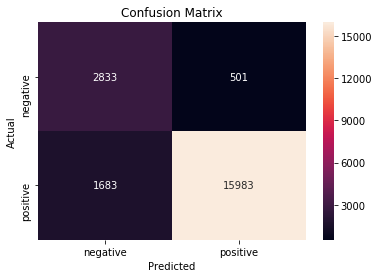


Confusion Matrix for Test data


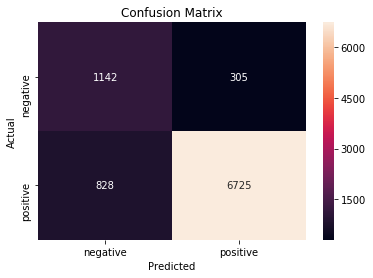

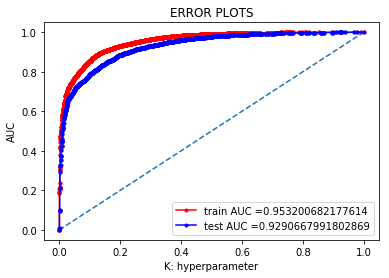


AUC (Train): 0.953200682177614

AUC (Test): 0.9290667991802869

F1 SCORE (Train) : 0.9360468521229868

F1 SCORE (Test) : 0.922306795583899

RECALL (Train): 0.9047322540473225

RECALL (Test): 0.8903746855554084

PRECISION  (Train) : 0.9696068915311817

PRECISION  (Test) : 0.9566145092460882


In [62]:
# https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/

X = final[:30000]
y = final['Score'][:30000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

mapper = DataFrameMapper([
     ('preprocessed_reviews', TfidfVectorizer(ngram_range=(1,3), min_df=10)),
     ('preprocessed_summary', TfidfVectorizer(ngram_range=(1,3), min_df=10)),
     ('numbers_of_words', None),
 ])

train_features = mapper.fit_transform(X_train)
test_features = mapper.transform(x_test)

optimal_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=1, verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(train_features,y_train)

# predict the response
test_pred = optimal_model.predict(test_features)
train_pred = optimal_model.predict(train_features)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,train_features, y_train,test_features, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [4.4] Word2Vec

In [35]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(53089,) (22753,) (53089,) (22753,)


In [36]:
# Train your own Word2Vec model using your own text corpus

# Train data
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# Test data
list_of_test_sentence = []
for sentance in x_test:
    list_of_test_sentence.append(sentance.split())

In [37]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # train data
    w2v_model_tr=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    # train model on test data
    w2v_model_test = Word2Vec(list_of_test_sentence,min_count=5,size=50, workers=4)
    print(w2v_model_tr.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_tr.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8428393006324768), ('fantastic', 0.8168098330497742), ('good', 0.8132688999176025), ('excellent', 0.795203685760498), ('terrific', 0.7875990867614746), ('perfect', 0.7722620368003845), ('wonderful', 0.7589964866638184), ('amazing', 0.7356107831001282), ('decent', 0.6817996501922607), ('nice', 0.6762537956237793)]
[('best', 0.7245468497276306), ('greatest', 0.7188271880149841), ('nastiest', 0.6999937295913696), ('experienced', 0.6946552395820618), ('tastiest', 0.6853335499763489), ('closest', 0.6236689686775208), ('horrible', 0.6169015169143677), ('awful', 0.6093588471412659), ('superior', 0.6016542911529541), ('terrible', 0.5935510993003845)]


In [38]:
# train data operation
w2v_train_words = list(w2v_model_tr.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[0:50])

number of words that occured minimum 5 times  13914
sample words  ['product', 'china', 'known', 'would', 'not', 'ordered', 'share', 'concerns', 'find', 'information', 'useful', 'rest', 'ignore', 'review', 'research', 'safety', 'bzzagent', 'recently', 'received', 'package', 'try', 'say', 'absolutely', 'love', 'flavor', 'candies', 'usually', 'big', 'candy', 'eater', 'really', 'impressed', 'werther', 'chewy', 'caramels', 'richly', 'flavored', 'could', 'stop', 'one', 'great', 'buttery', 'makes', 'mouth', 'water', 'thinking', 'like', 'fact', 'ingredients', 'cream']


In [39]:
## test data operation
w2v_test_words = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_test_words))
print("sample words ", w2v_test_words[0:50])

number of words that occured minimum 5 times  9272
sample words  ['recently', 'recieved', 'samples', 'energy', 'husband', 'son', 'used', 'next', 'morning', 'gotten', 'working', 'night', 'shift', 'law', 'hubby', 'work', 'car', 'took', 'shots', 'day', 'not', 'give', 'stay', 'awake', 'alert', 'enough', 'fix', 'also', 'fixed', 'built', 'kids', 'cut', 'fallen', 'yard', 'well', 'worth', 'cost', 'would', 'buy', 'use', 'received', 'free', 'sample', 'lot', 'family', 'hiking', 'grade', 'school', 'peanut', 'allergy']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [40]:
# average Word2Vec

# train data operation
exists = os.path.isfile(avg_w2v_trained_model_100000)
exists = False
if exists:
    print("yes exist")
    final_w2v_train = load(avg_w2v_trained_model_100000)
else:
    print("not exist")
    # compute average word2vec for each review.
    final_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words:
                vec = w2v_model_tr.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_train.append(sent_vec)
    print(len(final_w2v_train))
    print(len(final_w2v_train[0]))
#     dump(final_w2v_train,avg_w2v_trained_model_100000)


# test data operation
exists = os.path.isfile(avg_w2v_test_model_100000)
exists = False
if exists:
    print("yes exist")
    final_w2v_test = load(avg_w2v_test_model_100000)
else:
    print("not exist")
    final_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words:
                vec = w2v_model_test.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_test.append(sent_vec)
    print(len(final_w2v_test))
    print(len(final_w2v_test[0]))
#     dump(final_w2v_test,avg_w2v_test_model_100000)

  0%|          | 158/53089 [00:00<01:06, 792.10it/s]

not exist


  4%|▍         | 951/22753 [00:01<00:28, 767.98it/s] 

53089
50
not exist


100%|██████████| 22753/22753 [00:35<00:00, 701.68it/s]

22753
50


### Hyper param Tuning using GridSearch

##### finding 'max depth' which have maximum AUC Score

In [41]:
w2v_train_path = '/home/pranay/ML Hyperparam Tune/RF/w2v_train_hyperparam_tuned'
exists = os.path.isfile(w2v_train_path)

if exists:
    print("yes exists")
    w2v_train = load(w2v_train_path)
else:
    print("not exists")
    w2v_train = finding_best_hyperparam(final_w2v_train,y_train)
    dump(w2v_train,w2v_train_path )
    

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

best_depth_size = w2v_train.best_params_.get("max_depth", "")
best_estimators = w2v_train.best_params_.get("n_estimators", "")

yes exists
=======Training========
0.896785094849143
{'max_depth': 50, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1, verbose=0, warm_start=False)



AUC Train data


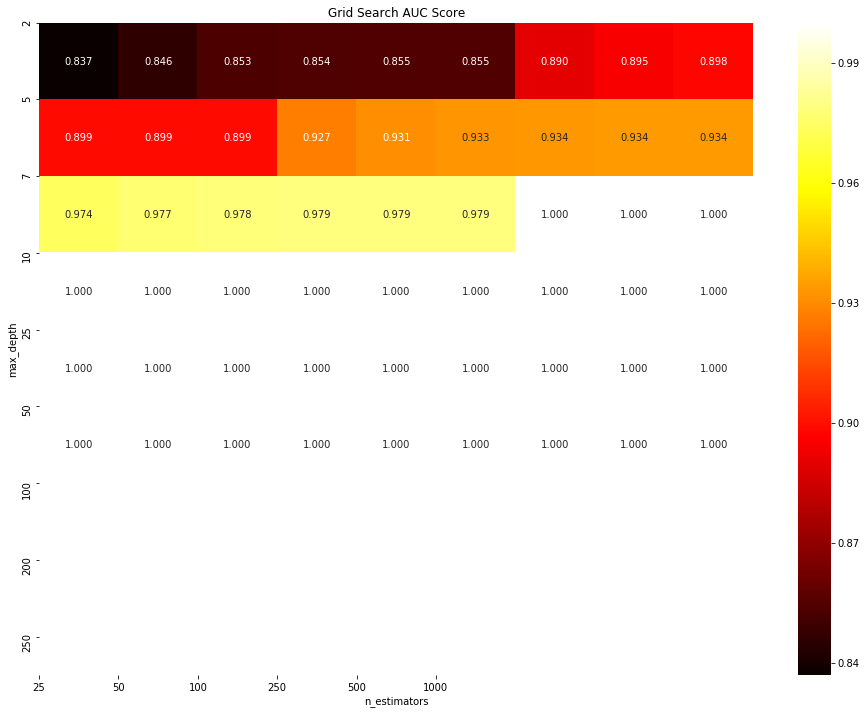

In [42]:
print('\n'+color.BOLD +'AUC Train data'+color.END)
plotHeatMap(w2v_train,'trained')


AUC Validation data


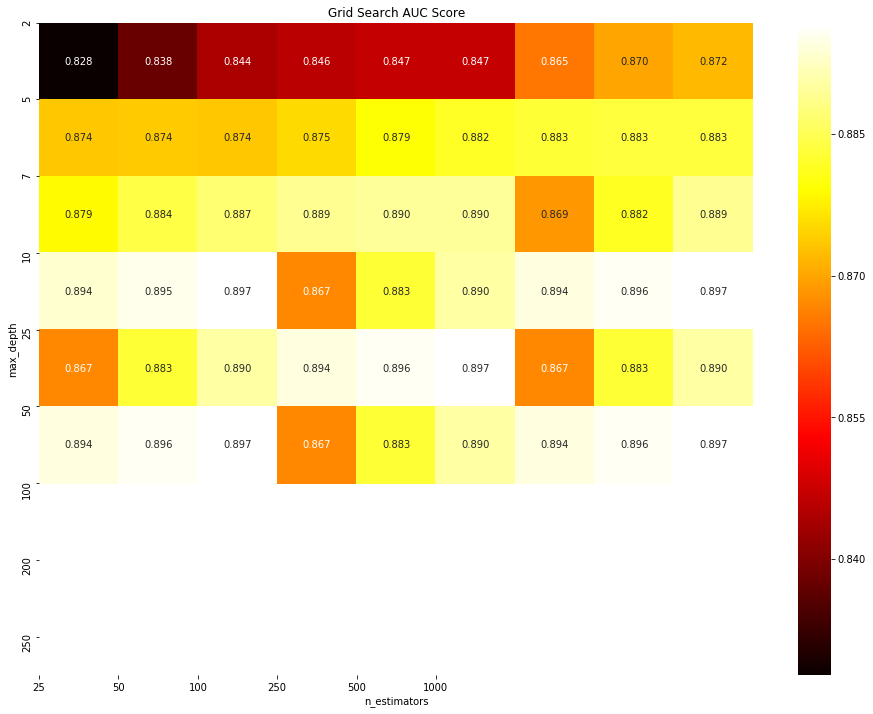

In [43]:
print('\n'+color.BOLD +'AUC Validation data'+color.END)
plotHeatMap(w2v_train,'test')


Max Depth : 5

Estimators : 500

Confusion Matrix for Train data


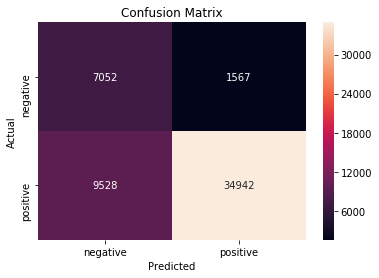


Confusion Matrix for Test data


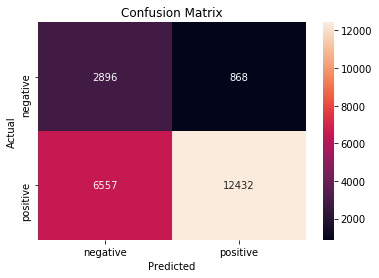

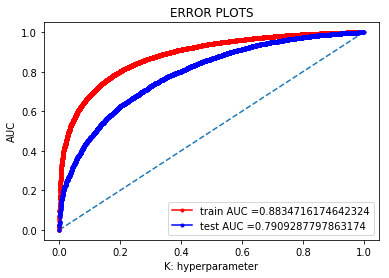


AUC (Train): 0.8834716174642324

AUC (Test): 0.7909287797863174

F1 SCORE (Train) : 0.8629891700317366

F1 SCORE (Test) : 0.7700455263402396

RECALL (Train): 0.7857431976613447

RECALL (Test): 0.6546948233187635

PRECISION  (Train) : 0.9570790763921225

PRECISION  (Test) : 0.9347368421052632


In [85]:
optimal_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(final_w2v_train, y_train)

# predict the response
test_pred = optimal_model.predict(final_w2v_test)
train_pred = optimal_model.predict(final_w2v_train)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(5)+color.END)
print('\n'+color.RED+'Estimators : '+color.END+color.BOLD+str(500)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)


## [4.4.1.2] TFIDF weighted W2v

In [54]:
X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(53089,) (22753,) (53089,) (22753,)


In [55]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [56]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TF-IDF weighted Word2Vec

# Train data operation

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_trained_model_100000)
exists = False
if exists:
    print("yes exist")
    final_tfidf_w2v_tr = load(w2v_tf_idf_trained_model_100000)
else:   
    print("not exist")
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    final_tfidf_w2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words and word in tfidf_feat:
                vec = w2v_model_tr.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_tr.append(sent_vec)
        row += 1
#     dump(final_tfidf_w2v_tr,w2v_tf_idf_trained_model_100000)
    
    
# Test data operation ============

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_test_model_100000)
exists = False
if exists:
    print("yes exist")
    final_tfidf_w2v_test = load(w2v_tf_idf_test_model_100000) 

else:   
    print("not exist")
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    final_tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words and word in tfidf_feat:
                vec = w2v_model_test.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_test.append(sent_vec)
        row += 1
#     dump(final_tfidf_w2v_test,w2v_tf_idf_test_model_100000)
        

  0%|          | 7/53089 [00:00<29:01, 30.48it/s]

not exist


  0%|          | 40/22753 [00:01<19:47, 19.12it/s]

not exist


100%|██████████| 22753/22753 [15:55<00:00, 22.85it/s]


### Hyper param Tuning using GridSearch

##### finding 'max depth' which have maximum AUC Score

In [57]:
tfidf_w2v_train_path = '/home/pranay/ML Hyperparam Tune/RF/tfidf_w2v_train_hyperparam_tuned'
exists = os.path.isfile(tfidf_w2v_train_path)

if exists:
    print("yes exists")
    w2v_tfidf_train = load(tfidf_w2v_train_path)
else:
    print("not exists")
    w2v_tfidf_train = finding_best_hyperparam(final_tfidf_w2v_tr,y_train)    
    dump(w2v_tfidf_train,tfidf_w2v_train_path )
    

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

best_depth_size = w2v_tfidf_train.best_params_.get("max_depth", "")
best_estimators = w2v_tfidf_train.best_params_.get("n_estimators", "")

yes exists
=======Training========
0.8729064577936415
{'max_depth': 100, 'n_estimators': 1000}
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=1, verbose=0, warm_start=False)



AUC Train data


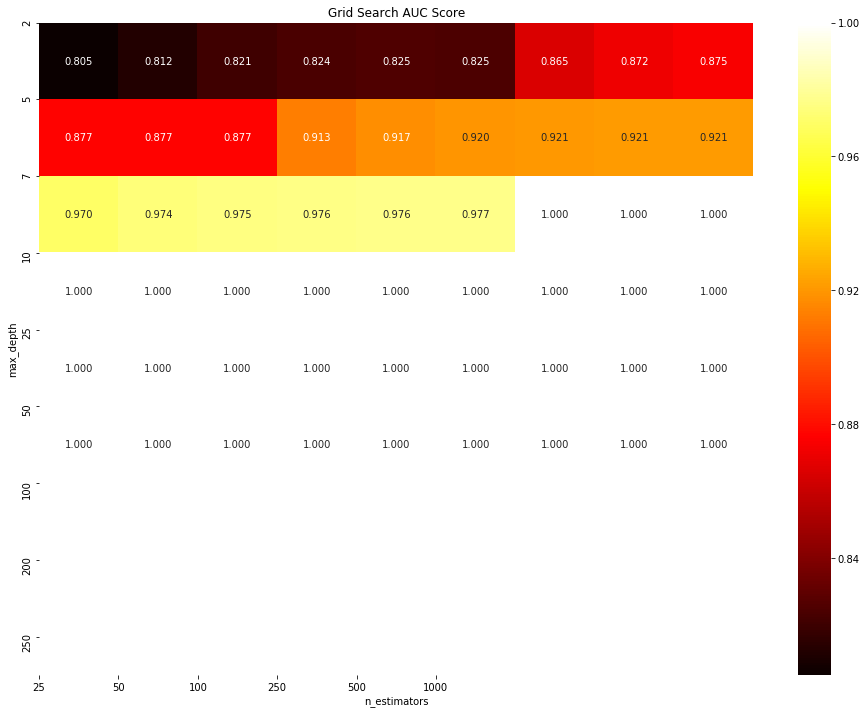

In [58]:
print('\n'+color.BOLD +'AUC Train data'+color.END)
plotHeatMap(w2v_tfidf_train,'trained')


AUC Validation data


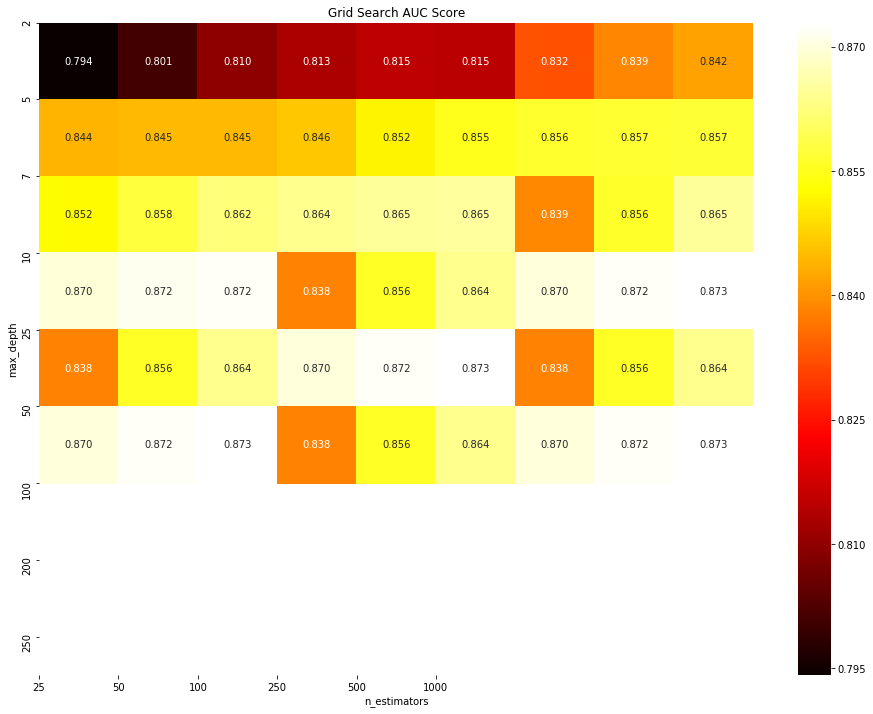

In [59]:
print('\n'+color.BOLD +'AUC Validation data'+color.END)
plotHeatMap(w2v_tfidf_train,'validation')

## Random Forest on TFIDF - W2V 


Max Depth : 4

Estimators: 500

Confusion Matrix for Train data


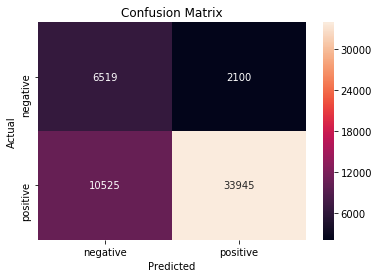


Confusion Matrix for Test data


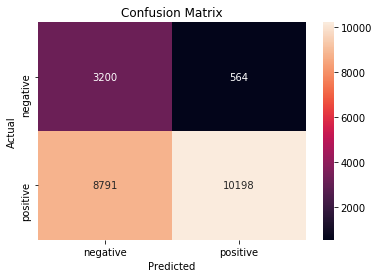

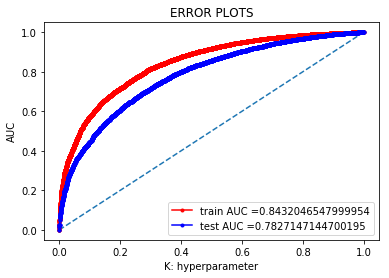


AUC (Train): 0.8432046547999954

AUC (Test): 0.7827147144700195

F1 SCORE (Train) : 0.8431969198286032

F1 SCORE (Test) : 0.6855567880071258

RECALL (Train): 0.7633235889363615

RECALL (Test): 0.5370477644952341

PRECISION  (Train) : 0.9417394923012901

PRECISION  (Test) : 0.947593384129344


In [65]:
optimal_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

# fitting the model
optimal_model.fit(final_tfidf_w2v_tr, y_train)

# predict the response
test_pred = optimal_model.predict(final_tfidf_w2v_test)
train_pred = optimal_model.predict(final_tfidf_w2v_tr)

print('\n'+color.RED+'Max Depth : '+color.END+color.BOLD+str(4)+color.END)
print('\n'+color.RED+'Estimators: '+color.END+color.BOLD+str(500)+color.END)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(optimal_model,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# [6] Conclusions

In [66]:
import pandas as pd
from prettytable import PrettyTable

print(color.BOLD+'\t\t\t\t Random Forest'+color.END)
print('\n')

print(color.BOLD+'For BOW and TFIDF, We have considered 85k points'+color.END)
print(color.BOLD+'For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 30k points'+color.END)


x = PrettyTable()
x.field_names =  ['Metric','BOW','BOW-Additional Feature', 'TFIDF', 'TFIDF- Additional Features','W2V','TFIDF-W2V']

x.add_row(["Max Depth ", 5,5,7,7,5,4])
x.add_row(["Min Sample Split ", 500,500,1000,1000,500,500])


x.add_row(["AUC Train ", 0.91414,0.93957,0.92812,0.95320,0.88347,0.84320])
x.add_row(["AUC Test ", 0.90540,0.92822,0.90995,0.92906,0.92906,0.78271])

x.add_row(["F1 SCORE Train ", 0.91560,0.92937,0.92039,0.93604,0.86298,0.84319])
x.add_row(["F1 SCORE Test ", 0.91240,0.92380,0.91212,0.92230,0.77045,0.68555])

x.add_row(["RECALL Train ",0.88342,0.89839,0.88707,0.90473,0.78579,0.76332])
x.add_row(["RECALL Test ", 0.88098,0.89328,0.88008,0.89037,0.65469,0.53704])
93449
x.add_row(["PRECISION Train ", 0.95022,0.96257,0.95633,0.96960,0.95707,0.94173])
x.add_row(["PRECISION Test ",0.94615,0.65647,0.94658,0.95661,0.93473,0.94759])


print('\n')
print(x)


				 Random Forest


For BOW and TFIDF, We have considered 85k points
For BOW- Additional Feature and TFIDF- Additional Feature, We have considered 30k points


+-------------------+---------+------------------------+---------+----------------------------+---------+-----------+
|       Metric      |   BOW   | BOW-Additional Feature |  TFIDF  | TFIDF- Additional Features |   W2V   | TFIDF-W2V |
+-------------------+---------+------------------------+---------+----------------------------+---------+-----------+
|     Max Depth     |    5    |           5            |    7    |             7              |    5    |     4     |
| Min Sample Split  |   500   |          500           |   1000  |            1000            |   500   |    500    |
|     AUC Train     | 0.91414 |        0.93957         | 0.92812 |           0.9532           | 0.88347 |   0.8432  |
|     AUC Test      |  0.9054 |        0.92822         | 0.90995 |          0.92906           | 0.92906 |  0.78271  |
|  F1 SCORE T